In [1]:
# Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

# Imorting required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from typing import Any
from collections import  defaultdict

# Importing require AI/ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score

# Setting functionality to see all the columns
pd.set_option('display.max_columns',None)

In [2]:
# Location of the datasets
train_data=r'C:\Users\DELL\train_depression.csv'
test_data=r'C:\Users\DELL\test_depression.csv'

In [3]:
# Locading the datasets in memory
df_train=pd.read_csv(train_data)
df_test=pd.read_csv(test_data)

In [4]:
#Extracting the Depression Column
y_train_final=df_train['Depression']

### Missing Value Imputation

In [5]:
# Checking the % of null entries
df_train.isnull().sum()/len(df_train)*100

id                                        0.000000
Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                     

In [6]:
# It is observed that certain columns have very low missing value count like Financial Stress , Degree & Dietary Habits
# So here the missing value imputation can be done by using straight forward methods like mean , median or mode 
# For that it is necessary to find out their data types
df_train.dtypes

id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

In [7]:
# Checking the Financial stress parameter --> It is clear that this column needs to be treated as a categorical variable
df_train['Financial Stress'].unique()

array([ 2.,  3.,  1.,  4.,  5., nan])

In [8]:
# Changing the data type of the Financial Stress to object
df_train['Financial Stress']=df_train['Financial Stress'].astype(object)

In [9]:
# Extracting the columns which have null values along with their data type
null_value_cols=[(col,round(100*null_values/len(df_train),2),df_train[col].dtype)
                 for col,null_values in df_train.isnull().sum().items() if null_values>0]

In [10]:
# Checking the null values along with their data types
null_value_cols

[('Profession', 26.03, dtype('O')),
 ('Academic Pressure', 80.17, dtype('float64')),
 ('Work Pressure', 19.84, dtype('float64')),
 ('CGPA', 80.17, dtype('float64')),
 ('Study Satisfaction', 80.17, dtype('float64')),
 ('Job Satisfaction', 19.84, dtype('float64')),
 ('Dietary Habits', 0.0, dtype('O')),
 ('Degree', 0.0, dtype('O')),
 ('Financial Stress', 0.0, dtype('O'))]

In [11]:
# I will extract the columns which have very low missing values
low_missing_values=[(col,dt) for col,missing_pct,dt in null_value_cols if missing_pct<1]

In [12]:
# Checking columns which have low missing value count and their dtypes
low_missing_values

[('Dietary Habits', dtype('O')),
 ('Degree', dtype('O')),
 ('Financial Stress', dtype('O'))]

In [13]:
# Imputing the missing values in the columns (with low missing values) and which are categorical in nature by using mode
very_low_missing_values=low_missing_values.copy()
for each_col,data_type in very_low_missing_values:
  df_train[each_col]=df_train[each_col].fillna(df_train[each_col].mode()[0])
  df_train[each_col]=df_train[each_col].astype(object)

In [14]:
# Checking the % of null entries
df_train.isnull().sum()/len(df_train)*100

id                                        0.000000
Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.000000
Degree                                    0.000000
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.000000
Family History of Mental Illness          0.000000
Depression                     

In [15]:
# Extracting the columns which have null values along with their data type and checking them once again
null_value_cols=[(col,round(100*null_values/len(df_train),2),df_train[col].dtype)
                 for col,null_values in df_train.isnull().sum().items() if null_values>0]

null_value_cols

[('Profession', 26.03, dtype('O')),
 ('Academic Pressure', 80.17, dtype('float64')),
 ('Work Pressure', 19.84, dtype('float64')),
 ('CGPA', 80.17, dtype('float64')),
 ('Study Satisfaction', 80.17, dtype('float64')),
 ('Job Satisfaction', 19.84, dtype('float64'))]

In [16]:
# I decided to write a function to identify the columns which very high percentage of missing values and then just imputing missing values by a place holder 
# But before going ahead I decided to check the nature of the columns with these high missing values
high_missing_values=[(col,dt) for col,missing_pct,dt in null_value_cols if missing_pct>50]
high_missing_values

[('Academic Pressure', dtype('float64')),
 ('CGPA', dtype('float64')),
 ('Study Satisfaction', dtype('float64'))]

In [17]:
#Just extracting the column names of the columns with high missing values
col_names_high_missing_value=[each_col for each_col,data_type in high_missing_values]

# Doing a quick analysis of the columns with high missing values 
def analyze_missing_value_columns(dataframe,high_missing_value_col):

  """
  This function will take data frame & the columns with high missing values.
    Then it will show the number of unique values in column with some statistical information of the selected column
    
    Args: Dataframe & columns with high missing values
    
    Returns : Unique values in the columns and statistics for the column
  """

  for each_col in high_missing_value_col:
    print(f'For {each_col}')
    print(f'The number of unique values are {dataframe[each_col].nunique()}' )
    print(f'The statistics are {dataframe[each_col].describe()}' )
    if dataframe[each_col].nunique()<=10:
      print(f'The unique values are {dataframe[each_col].unique()} \n')
    else:
      print('\n')
    


In [18]:
# Using the modular function to check the details for all columns with high missing values
analyze_missing_value_columns(df_train,col_names_high_missing_value)

For Academic Pressure
The number of unique values are 5
The statistics are count    27897.000000
mean         3.142273
std          1.380457
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Academic Pressure, dtype: float64
The unique values are [nan  5.  2.  3.  4.  1.] 

For CGPA
The number of unique values are 331
The statistics are count    27898.000000
mean         7.658636
std          1.464466
min          5.030000
25%          6.290000
50%          7.770000
75%          8.920000
max         10.000000
Name: CGPA, dtype: float64


For Study Satisfaction
The number of unique values are 5
The statistics are count    27897.000000
mean         2.944940
std          1.360197
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Study Satisfaction, dtype: float64
The unique values are [nan  2.  5.  3.  4.  1.] 



In [19]:
# I decided to check the nature of the columns with low missing values
low_missing_values=[(col,dt) for col,missing_pct,dt in null_value_cols if missing_pct<30]
low_missing_values

[('Profession', dtype('O')),
 ('Work Pressure', dtype('float64')),
 ('Job Satisfaction', dtype('float64'))]

In [20]:
#Just extracting the column names of the columns with high missing values
col_names_low_missing_value=[each_col for each_col,data_type in low_missing_values]

# Using the modular function to check the details for all columns with low missing values
analyze_missing_value_columns(df_train,col_names_low_missing_value)

For Profession
The number of unique values are 64
The statistics are count      104070
unique         64
top       Teacher
freq        24906
Name: Profession, dtype: object


For Work Pressure
The number of unique values are 5
The statistics are count    112782.000000
mean          2.998998
std           1.405771
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: Work Pressure, dtype: float64
The unique values are [ 5.  4. nan  1.  2.  3.] 

For Job Satisfaction
The number of unique values are 5
The statistics are count    112790.000000
mean          2.974404
std           1.416078
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: Job Satisfaction, dtype: float64
The unique values are [ 2.  3. nan  1.  5.  4.] 



## Based upon the above given findings it was clear 
### That I will be using the XGBoost Calssifier for the missing value imputation of Job Satisfaction and work pressure
### But for Profession considering the High Cardinality first I will be replacing the null values with "missing value" & then I will be using the frequncy encoding for the same

In [21]:
# Making small bins of the CGPA 
def CGPA_BIN(CGPA_VALUE):
  if CGPA_VALUE<5:
    return "Less than 5"
  elif CGPA_VALUE>=5 and CGPA_VALUE<=6:
    return "5-6"
  elif CGPA_VALUE>=6 and CGPA_VALUE<=7:
    return "6-7"
  elif CGPA_VALUE>=7 and CGPA_VALUE<=8:
    return "7-8"
  elif CGPA_VALUE>=8 and CGPA_VALUE<=9:
    return "8-9"
  elif CGPA_VALUE>=9 and CGPA_VALUE<=10:
    return "9-10"  

In [22]:
# Replacing the CGPA column
df_train.CGPA=df_train.CGPA.apply(lambda x : CGPA_BIN(x))

In [23]:
# It is also clear that the Study satisfaction & the academic pressure needs to be treated as a categorical variable
df_train['Academic Pressure']=df_train['Academic Pressure'].astype(object)
df_train['Study Satisfaction']=df_train['Study Satisfaction'].astype(object)

In [24]:
# Now replacing the missing values in Study satisfaction, CGPA & the academic pressure with "Missing Value"
df_train['Academic Pressure']=df_train['Academic Pressure'].fillna("Missing_Value")
df_train['Study Satisfaction']=df_train['Study Satisfaction'].fillna("Missing_Value")
df_train['CGPA']=df_train['CGPA'].fillna("Missing_Value")

In [25]:
# Replacing the Missing Profession values with "Missing Values" & then using the frequncy encoding
df_train['Profession']=df_train['Profession'].fillna('Missing Value')

In [26]:
# Here I decided to first preprocess the columns which do not have any missing values &
# Then use them to predict the columns which had missing values 
# Checking the % of null entries
col_series=df_train.isnull().sum()/len(df_train)*100
col_series=[col for col,missing_value in col_series.items() if missing_value==0 ]

# De selecting the columns which will not have much significance & I want to keep preofession col for preprocessing
col_series=[col for col in col_series if col not in ['Depression','id','Name']]

In [27]:
# Making a dataframe for preprocssing
df_for_missing_val_imputation=df_train[col_series]

In [28]:
# Chceking the first 5 rows
df_for_missing_val_imputation.head()

,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,Female,49.0,Ludhiana,Working Professional,Chef,Missing_Value,Missing_Value,Missing_Value,More than 8 hours,Healthy,BHM,No,1.0,2.0,No
1,Male,26.0,Varanasi,Working Professional,Teacher,Missing_Value,Missing_Value,Missing_Value,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No
2,Male,33.0,Visakhapatnam,Student,Missing Value,5.0,8-9,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No
3,Male,22.0,Mumbai,Working Professional,Teacher,Missing_Value,Missing_Value,Missing_Value,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes
4,Female,30.0,Kanpur,Working Professional,Business Analyst,Missing_Value,Missing_Value,Missing_Value,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes


In [29]:
# Checking the dtypes again
df_for_missing_val_imputation.dtypes

Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                         object
CGPA                                      object
Study Satisfaction                        object
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
dtype: object

In [30]:
# Checking the number of unique values per column in the given dataframe 
df_for_missing_val_imputation.nunique()

Gender                                     2
Age                                       43
City                                      98
Working Professional or Student            2
Profession                                65
Academic Pressure                          6
CGPA                                       6
Study Satisfaction                         6
Sleep Duration                            36
Dietary Habits                            23
Degree                                   115
Have you ever had suicidal thoughts ?      2
Work/Study Hours                          13
Financial Stress                           5
Family History of Mental Illness           2
dtype: int64

### I decided to use the frequency encoding to encode the columns which have high cardinality

In [31]:
# The columns with clear high cardinality are where the unique values are above 20 
# Also the columns which I decided to short list for the analysis of whether to use frequncy encoding depended the data data type
col_for_freq_encoding=[col for col in df_for_missing_val_imputation.columns if (df_for_missing_val_imputation[col].nunique()>20) and (df_for_missing_val_imputation[col].dtype==object) ]

In [32]:
# Printing unique values in each column of dataframe
for col in col_for_freq_encoding:
  print(f'The {col} has below given unique values \n {df_for_missing_val_imputation[col].unique()} \n \n')

The City has below given unique values 
 ['Ludhiana' 'Varanasi' 'Visakhapatnam' 'Mumbai' 'Kanpur' 'Ahmedabad'
 'Thane' 'Nashik' 'Bangalore' 'Patna' 'Rajkot' 'Jaipur' 'Pune' 'Lucknow'
 'Meerut' 'Agra' 'Surat' 'Faridabad' 'Hyderabad' 'Srinagar' 'Ghaziabad'
 'Kolkata' 'Chennai' 'Kalyan' 'Nagpur' 'Vadodara' 'Vasai-Virar' 'Delhi'
 'Bhopal' 'Indore' 'Ishanabad' 'Vidhi' 'Ayush' 'Gurgaon' 'Krishna'
 'Aishwarya' 'Keshav' 'Harsha' 'Nalini' 'Aditya' 'Malyansh' 'Raghavendra'
 'Saanvi' 'M.Tech' 'Bhavna' 'Less Delhi' 'Nandini' 'M.Com' 'Plata'
 'Atharv' 'Pratyush' 'City' '3.0' 'Less than 5 Kalyan' 'MCA' 'Mira'
 'Moreadhyay' 'Morena' 'Ishkarsh' 'Kashk' 'Mihir' 'Vidya' 'Tolkata' 'Anvi'
 'Krinda' 'Ayansh' 'Shrey' 'Ivaan' 'Vaanya' 'Gaurav' 'Harsh' 'Reyansh'
 'Kashish' 'Kibara' 'Vaishnavi' 'Chhavi' 'Parth' 'Mahi' 'Tushar' 'MSc'
 'No' 'Rashi' 'ME' 'Molkata' 'Researcher' 'Kagan' 'Armaan' 'Ithal'
 'Nalyan' 'Dhruv' 'Galesabad' 'Itheg' 'Aaradhya' 'Pooja' 'Khushi'
 'Khaziabad' 'Jhanvi' 'Unirar'] 
 

The Profess

In [33]:
# Further analysing the columns which have high cardinality
for col in col_for_freq_encoding:
  print(f'The top 5 contributors for {col} are \n {(df_for_missing_val_imputation[col].value_counts()/len(df_for_missing_val_imputation)).head()} \n')

The top 5 contributors for City are 
 Kalyan         0.046844
Patna          0.042104
Vasai-Virar    0.040974
Kolkata        0.040434
Ahmedabad      0.039893
Name: City, dtype: float64 

The top 5 contributors for Profession are 
 Missing Value     0.260341
Teacher           0.177015
Content Writer    0.055537
Architect         0.031059
Consultant        0.030057
Name: Profession, dtype: float64 

The top 5 contributors for Sleep Duration are 
 Less than 5 hours    0.275650
7-8 hours            0.262751
More than 8 hours    0.232594
5-6 hours            0.228443
3-4 hours            0.000085
Name: Sleep Duration, dtype: float64 

The top 5 contributors for Dietary Habits are 
 Moderate     0.353298
Unhealthy    0.328550
Healthy      0.317989
Yes          0.000014
No           0.000014
Name: Dietary Habits, dtype: float64 

The top 5 contributors for Degree are 
 Class 12    0.104698
B.Ed        0.083092
B.Arch      0.062132
B.Com       0.057662
B.Pharm     0.041620
Name: Degree, dtype:

In [34]:
# Based upon the above observations I decided to use one hot encoding for the Dietary habits and Sleep Duration
sleep_duration=list(df_for_missing_val_imputation['Sleep Duration'].value_counts().keys()[:4])
dietary_habits=list(df_for_missing_val_imputation['Dietary Habits'].value_counts().keys()[:3])

In [35]:
# Defining a function to handle the sleep duration & the dietray habits column
def sleep_diet_update(entry,ref_list):
  if entry in ref_list:
    return entry
  else:
    return 'Others'

In [36]:
# Updating the sleep duration and dietary habits columns
df_for_missing_val_imputation['Sleep Duration']=df_for_missing_val_imputation['Sleep Duration'].apply(lambda x:sleep_diet_update(x,sleep_duration))
df_for_missing_val_imputation['Dietary Habits']=df_for_missing_val_imputation['Dietary Habits'].apply(lambda x:sleep_diet_update(x,dietary_habits))

In [37]:
# Starting the frequency encoding
freq_degree=df_for_missing_val_imputation['Degree'].value_counts()
freq_city=df_for_missing_val_imputation['City'].value_counts()
freq_prof=df_for_missing_val_imputation['Profession'].value_counts()

# Mapping the frequency
df_for_missing_val_imputation['Degree']=df_for_missing_val_imputation['Degree'].map(freq_degree)
df_for_missing_val_imputation['City']=df_for_missing_val_imputation['City'].map(freq_city)
df_for_missing_val_imputation['Profession']=df_for_missing_val_imputation['Profession'].map(freq_prof)

In [38]:
# Checking the unique values once again
df_for_missing_val_imputation.nunique()

Gender                                    2
Age                                      43
City                                     35
Working Professional or Student           2
Profession                               41
Academic Pressure                         6
CGPA                                      6
Study Satisfaction                        6
Sleep Duration                            5
Dietary Habits                            4
Degree                                   32
Have you ever had suicidal thoughts ?     2
Work/Study Hours                         13
Financial Stress                          5
Family History of Mental Illness          2
dtype: int64

In [39]:
# Checking the data types once again
df_for_missing_val_imputation.dtypes

Gender                                    object
Age                                      float64
City                                       int64
Working Professional or Student           object
Profession                                 int64
Academic Pressure                         object
CGPA                                      object
Study Satisfaction                        object
Sleep Duration                            object
Dietary Habits                            object
Degree                                     int64
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
dtype: object

In [40]:
# Now making a list of columns which I will be using to make dummy columns
dummy_cols=[col for col in df_for_missing_val_imputation.columns if df_for_missing_val_imputation[col].dtype==object]

In [41]:
# Making a dataframe with dummy columns
df_dummies=pd.get_dummies(data=df_for_missing_val_imputation,columns=dummy_cols,drop_first=True)

In [42]:
# Taking the variables which are float and then using the scaler on them
float_cols=[col for col in df_for_missing_val_imputation.columns if df_for_missing_val_imputation[col].dtype==float]

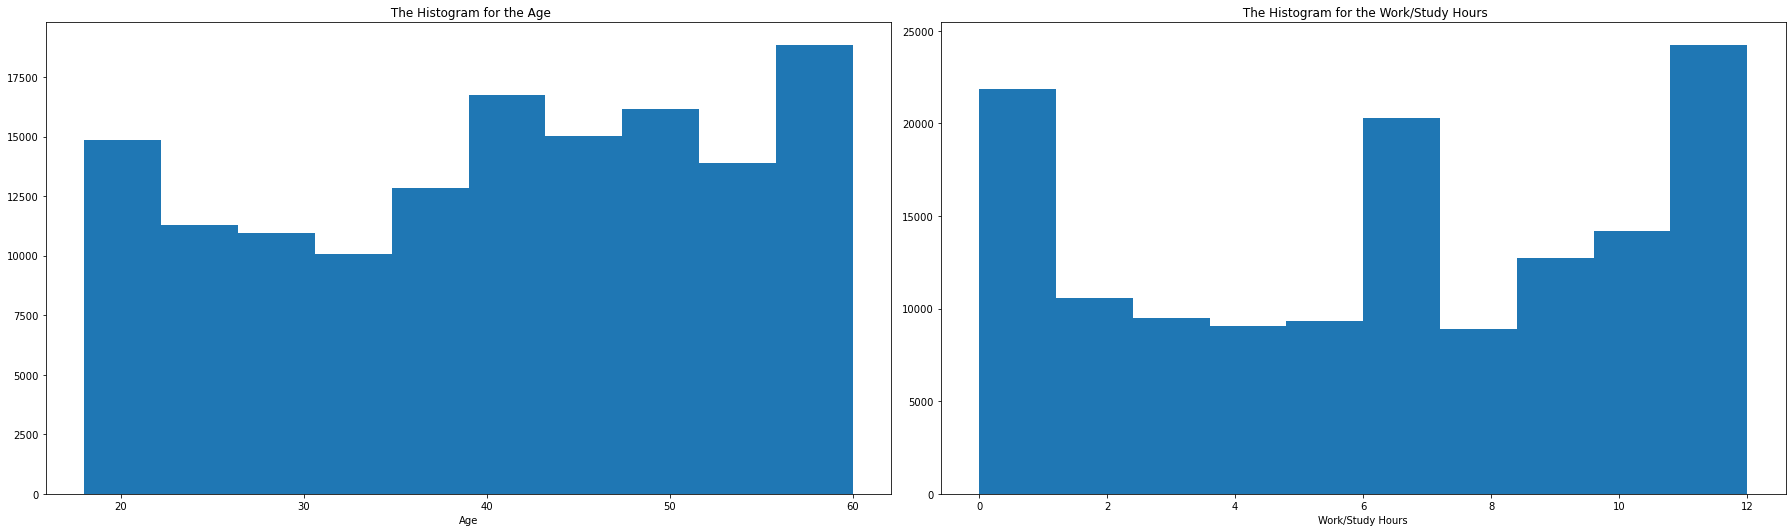

In [43]:
# Making a quick "for" loop to chake the distribution of all the numerical variables to decide which scaler to use
col_no=2
row_no=(len(float_cols)+1)//col_no
fig,axes=plt.subplots(nrows=row_no,ncols=col_no,figsize=(25,7.5))
axes=axes.flatten()

# Iterating through each col and then plotting the histogram
for col_num,col in enumerate(float_cols):
  ax=axes[col_num]
  ax.hist(x=df_dummies[col],bins=10)
  ax.set_title(f" The Histogram for the {col}")
  ax.set_xlabel(f'{col}')

# Deleting the unused plots
for col_to_del in range(col_num+1,len(float_cols)):
  fig.delaxes(ax=axes[col_num])

plt.tight_layout()
plt.show()


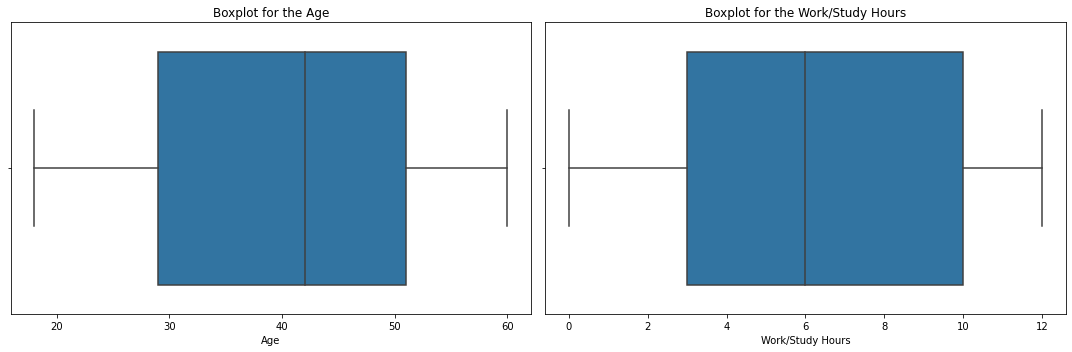

In [44]:
# Making a quick "for" loop to iterate through the continuous variable columns and then plotting their boxplot to check for outliers

col_no=2
row_no=(len(float_cols)+1)//2
fig,axes=plt.subplots(nrows=row_no,ncols=col_no,figsize=(15,5))
axes=axes.flatten()

# Iterating through each col and then plotting the boxplot
for col_num,col in enumerate(float_cols):
  sns.boxplot(ax=axes[col_num],data=df_dummies,x=col)
  axes[col_num].set_title(f"Boxplot for the {col}")

# Deleting the unused subplots
for col_to_del in range(col_num+1,len(float_cols)):
  fig.delaxes(ax=axes[col_to_del])

plt.tight_layout()
plt.show()


In [45]:
# Using the MinMax scaler as the data in the columns do not follow normal distribution and does not have outliers
scaler_age=MinMaxScaler()
scaler_work_study_hours=MinMaxScaler()

In [46]:
# Fit and transform the continuous variables
df_dummies['Age']=scaler_age.fit_transform(np.array(df_dummies['Age']).reshape(-1,1))
df_dummies['Work/Study Hours']=scaler_work_study_hours.fit_transform(np.array(df_dummies['Work/Study Hours']).reshape(-1,1))

In [47]:
# Checking df_dummies
df_dummies.head()

,Age,City,Profession,Degree,Work/Study Hours,Gender_Male,Working Professional or Student_Working Professional,Academic Pressure_2.0,Academic Pressure_3.0,Academic Pressure_4.0,Academic Pressure_5.0,Academic Pressure_Missing_Value,CGPA_6-7,CGPA_7-8,CGPA_8-9,CGPA_9-10,CGPA_Missing_Value,Study Satisfaction_2.0,Study Satisfaction_3.0,Study Satisfaction_4.0,Study Satisfaction_5.0,Study Satisfaction_Missing_Value,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Sleep Duration_Others,Dietary Habits_Moderate,Dietary Habits_Others,Dietary Habits_Unhealthy,Have you ever had suicidal thoughts ?_Yes,Financial Stress_2.0,Financial Stress_3.0,Financial Stress_4.0,Financial Stress_5.0,Family History of Mental Illness_Yes
0,0.738095,5226,2862,4305,0.083333,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0.190476,4606,24906,4348,0.583333,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0
2,0.357143,5176,36630,5856,0.250000,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.095238,4966,24906,5030,0.833333,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1
4,0.285714,4398,3161,5030,0.750000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1


In [48]:
# Cross veryfying if all the columns do not have any null entries 
df_dummies.isnull().sum()

Age                                                     0
City                                                    0
Profession                                              0
Degree                                                  0
Work/Study Hours                                        0
Gender_Male                                             0
Working Professional or Student_Working Professional    0
Academic Pressure_2.0                                   0
Academic Pressure_3.0                                   0
Academic Pressure_4.0                                   0
Academic Pressure_5.0                                   0
Academic Pressure_Missing_Value                         0
CGPA_6-7                                                0
CGPA_7-8                                                0
CGPA_8-9                                                0
CGPA_9-10                                               0
CGPA_Missing_Value                                      0
Study Satisfac

In [49]:
# Checking the data type
df_dummies.dtypes

Age                                                     float64
City                                                      int64
Profession                                                int64
Degree                                                    int64
Work/Study Hours                                        float64
Gender_Male                                               uint8
Working Professional or Student_Working Professional      uint8
Academic Pressure_2.0                                     uint8
Academic Pressure_3.0                                     uint8
Academic Pressure_4.0                                     uint8
Academic Pressure_5.0                                     uint8
Academic Pressure_Missing_Value                           uint8
CGPA_6-7                                                  uint8
CGPA_7-8                                                  uint8
CGPA_8-9                                                  uint8
CGPA_9-10                               

In [50]:
# Extracting the columns which need missing value imputation by using advanced ML algorithms
[col for col in df_train.columns if col not in col_series]

['id', 'Name', 'Work Pressure', 'Job Satisfaction', 'Depression']

In [51]:
# Even if the missing value imputation is required for certain columns still it was necessary to drop Depression, id & Name 
cols_unnecessary=['id', 'Name', 'Depression']
col_to_impute=[col for col in df_train.columns if (col not in col_series) and (col not in cols_unnecessary) ]

In [52]:
# Extracting the columns which are to be imputed from the training dataframe
df_impute=df_train[col_to_impute]

In [53]:
# Concatenating the two dataframes for missing values imputation by using the ML
df_train=pd.concat([df_impute,df_dummies],axis=1)

In [54]:
#Checking the top 5 rows
df_train.head()

,Work Pressure,Job Satisfaction,Age,City,Profession,Degree,Work/Study Hours,Gender_Male,Working Professional or Student_Working Professional,Academic Pressure_2.0,Academic Pressure_3.0,Academic Pressure_4.0,Academic Pressure_5.0,Academic Pressure_Missing_Value,CGPA_6-7,CGPA_7-8,CGPA_8-9,CGPA_9-10,CGPA_Missing_Value,Study Satisfaction_2.0,Study Satisfaction_3.0,Study Satisfaction_4.0,Study Satisfaction_5.0,Study Satisfaction_Missing_Value,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Sleep Duration_Others,Dietary Habits_Moderate,Dietary Habits_Others,Dietary Habits_Unhealthy,Have you ever had suicidal thoughts ?_Yes,Financial Stress_2.0,Financial Stress_3.0,Financial Stress_4.0,Financial Stress_5.0,Family History of Mental Illness_Yes
0,5.0,2.0,0.738095,5226,2862,4305,0.083333,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
1,4.0,3.0,0.190476,4606,24906,4348,0.583333,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0
2,NaN,NaN,0.357143,5176,36630,5856,0.250000,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,5.0,1.0,0.095238,4966,24906,5030,0.833333,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1
4,1.0,1.0,0.285714,4398,3161,5030,0.750000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1


In [55]:
# Creating an index column so that merging will be easier in future 
df_train.insert(loc=0,column='Index',value=df_train.index)

In [56]:
# Dropping the other target imputation columns
job_train_data=df_train.drop(['Work Pressure'],axis=1)
work_train_data=df_train.drop(['Job Satisfaction'],axis=1)

In [57]:
# Making datasets for training the algorithm to impute the missing values

df_job_train=job_train_data[~job_train_data['Job Satisfaction'].isnull()]
df_job_test=job_train_data[job_train_data['Job Satisfaction'].isnull()]

df_work_train=work_train_data[~work_train_data['Work Pressure'].isnull()]
df_work_test=work_train_data[work_train_data['Work Pressure'].isnull()]

### The below given model buidling step can be automised by defining a function / class in future

#### For finding out the Job Satisfaction for the missing entries

In [58]:
# Extracting the required variables for training 
y_train=df_job_train['Job Satisfaction'].astype(int)
X_train=df_job_train.copy()
X_train.pop('Job Satisfaction')
X_test=df_job_test.drop(['Job Satisfaction'],axis=1)

# The values of y should start from 0 in order to apply the XGBoost algorithm
y_train=y_train-1

In [59]:
# Preparing the model 
model_job= xgb.XGBClassifier(
                          objective='multi:softmax',
                          num_class=y_train.nunique(),
                          eval_metric='mlogloss',
                          max_depth=5,
                          eta=0.1
                          )

# Fitting the model
model_job.fit(X=X_train,y=y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=5, num_parallel_tree=None, ...)

In [60]:
# Predicting the outputs for test data
y_test=model_job.predict(X_test)

# Creating a new dataframe of y_test
y_test=pd.DataFrame(y_test,columns=['Job Satisfaction'])

# Resetting the index as using concat will have problems when the indices of the y_test & X_test will be different
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

# Concatenating the X_test & y _test
df_job_test=pd.concat([y_test,X_test],axis=1)


#### For finding out the Work Pressure for the missing entries

In [61]:
# Extracting the required variables for training 
y_train=df_work_train['Work Pressure'].astype(int)
X_train=df_work_train.copy()
X_train.pop('Work Pressure')
X_test=df_work_test.drop(['Work Pressure'],axis=1)

# The values of y should start from 0 in order to apply the XGBoost algorithm
y_train=y_train-1

In [62]:
# Preparing the model 
model_work= xgb.XGBClassifier(
                          objective='multi:softmax',
                          num_class=y_train.nunique(),
                          eval_metric='mlogloss',
                          max_depth=5,
                          eta=0.1
                          )

# Fitting the model
model_work.fit(X=X_train,y=y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=5, num_parallel_tree=None, ...)

In [63]:
# Predicting the outputs for test data
y_test=model_work.predict(X_test)

# Creating a new dataframe of y_test
y_test=pd.DataFrame(y_test,columns=['Work Pressure'])

# Resetting the index as using concat will have problems when the indices of the y_test & X_test will be different
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

# Concatenating the X_test & y _test
df_work_test=pd.concat([y_test,X_test],axis=1)

In [64]:
# Concatenating the dataframes vertically

df_work_test.reset_index(drop=True,inplace=True)
df_work_train.reset_index(drop=True,inplace=True)
df_job_test.reset_index(drop=True,inplace=True)
df_job_train.reset_index(drop=True,inplace=True)

df_work=pd.concat([df_work_test,df_work_train],axis=0)
df_job=pd.concat([df_job_test,df_job_train],axis=0)

In [65]:
# Merging the dataframes
sep_suffix="_to_drop"
df_train=pd.merge(left=df_work,right=df_job,on='Index',suffixes=["",sep_suffix])
col_to_drop=[col for col in df_train.columns if sep_suffix not in col]
df_train=df_train[col_to_drop]

In [66]:
# Using the previously defined indexes to use them again as index
df_train.set_index(df_train['Index'],inplace=True)
df_train.sort_index(inplace=True)

cols_rqd=[col for col in df_train.columns if 'Index' not in col ]
df_train=df_train[cols_rqd]

### Even though for job and work I can do one hot encoding , I will opt not to do it as XGBoost can handle this effectively.

In [67]:
# Adding the depression column for training
df_train.insert(loc=0,column='Depression',value=y_train_final)

In [68]:
# Making a copy of the dataset( Before going for final model ) --> Will be deleted in next revisions
df=df_train.copy()

In [69]:
# Extracting X& y
y=df.pop('Depression')
X=df.copy()

In [70]:
# Doing the train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [71]:
# Defining the model
model= xgb.XGBClassifier(
                          objective='binary:logistic',
                          eval_metric='logloss',
                          max_depth=5,
                          eta=0.3,
                          n_estimators=100
                          )

In [72]:
# Fitting the model
model.fit(X=X_train,y=y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [73]:
# Predicting for unseen data
y_pred=model.predict(X_test)

In [74]:
# Calculating the confusion matrix
confusion_matrix(y_true=y_test,y_pred=y_pred)

array([[27747,   973],
       [ 1207,  5248]], dtype=int64)

In [75]:
# Calculating accuracy score --> But will need to improve the study by using precison and recall so that we do not miss anyone who is suffering from depression
accuracy_score(y_test,y_pred)

0.9380241648898365

### Checking the performance on the train dataset

In [76]:
# Checking the performance on the train data set
y_pred=model.predict(X_train)

In [77]:
# Calculating the confusion matrix
confusion_matrix(y_true=y_train,y_pred=y_pred)

array([[84019,  2394],
       [ 3099, 16013]], dtype=int64)

In [78]:
# Calculating the accuracy score
accuracy_score(y_train,y_pred)

0.9479459843638948

### Fitting the model on the whole train data set & Checking the performance

In [79]:
# Initialize and train CatBoost
model_cat = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=5,
    verbose=10
)


In [80]:
### Now using the whole dataset to train the model & this model will be used to finally validate the performance on Kaggle
model_cat.fit(X=X,y=y)

0:	learn: 0.6146373	total: 195ms	remaining: 6m 29s
10:	learn: 0.2879749	total: 529ms	remaining: 1m 35s
20:	learn: 0.2257676	total: 849ms	remaining: 1m 20s
30:	learn: 0.1977201	total: 1.41s	remaining: 1m 29s
40:	learn: 0.1855574	total: 1.73s	remaining: 1m 22s
50:	learn: 0.1778487	total: 2.05s	remaining: 1m 18s
60:	learn: 0.1730587	total: 2.38s	remaining: 1m 15s
70:	learn: 0.1694638	total: 2.65s	remaining: 1m 11s
80:	learn: 0.1666958	total: 2.92s	remaining: 1m 9s
90:	learn: 0.1643954	total: 3.19s	remaining: 1m 6s
100:	learn: 0.1626503	total: 3.45s	remaining: 1m 4s
110:	learn: 0.1610914	total: 3.73s	remaining: 1m 3s
120:	learn: 0.1599274	total: 4.11s	remaining: 1m 3s
130:	learn: 0.1585965	total: 4.4s	remaining: 1m 2s
140:	learn: 0.1576382	total: 5.03s	remaining: 1m 6s
150:	learn: 0.1568937	total: 5.63s	remaining: 1m 8s
160:	learn: 0.1561334	total: 5.98s	remaining: 1m 8s
170:	learn: 0.1554378	total: 6.31s	remaining: 1m 7s
180:	learn: 0.1549100	total: 6.59s	remaining: 1m 6s
190:	learn: 0.15

In [81]:
# Predicting for whole train data
y_pred=model_cat.predict(X)

In [82]:
# Calculating the confusion matrix
confusion_matrix(y_true=y,y_pred=y_pred)

array([[111962,   3171],
       [  4065,  21502]], dtype=int64)

In [83]:
# Calculating the accuracy score
accuracy_score(y,y_pred)

0.9485714285714286

### Pre-processing the test dataset so that final model can be used for the prediction 

In [84]:
# Reading the train data again to copare the missing values in the test and train dataset
df_train_check=pd.read_csv(train_data)

In [85]:
# I decided to check the missing the values in test dataset and training dataset, to confirm if I can use the same strategy of missing value imputation on test data set as I used it on the train dataset
def missing_value_comparae_train_test(train_data:pd.DataFrame,test_data:pd.DataFrame)->pd.DataFrame:
  """
  Comparing the missing values in the training and testing dataset for the common columns.

  Args :
  train_data : Training Dataset
  test_data : Testing Dataset

  Returns:

  A Data Frame showing the common columns along with their missing values  
  
  """

  # Checking if the common columns are available in the train and test dataset
  common_columns=sorted(set(train_data.columns).intersection(set(test_data.columns)))

  # Initiating missing values dictionary
  missing_value_dict=defaultdict(list)

  # Now iterating through each column
  for each_col in common_columns:

    # Extracting the required missing values for train and test 
    train_missing=train_data[each_col].isnull().sum()
    test_missing=test_data[each_col].isnull().sum() 

    # Checking if missing values are present
    if train_missing!=0 or test_missing!=0:
      missing_value_dict['Column_Name'].append(each_col)
      missing_value_dict['Missing Values in Training Data'].append(train_missing)
      missing_value_dict['Missing Values in Testing Data'].append(test_missing)
      
  df=pd.DataFrame(missing_value_dict)

  return df


In [86]:
# Checking the missing values in train & test data set
missing_value_comparae_train_test(df_train_check,df_test)

,Column_Name,Missing Values in Training Data,Missing Values in Testing Data
0,Academic Pressure,112803,75033
1,CGPA,112802,75034
2,Degree,2,2
3,Dietary Habits,4,5
4,Financial Stress,4,0
5,Job Satisfaction,27910,18774
6,Profession,36630,24632
7,Study Satisfaction,112803,75033
8,Work Pressure,27918,18778


In [87]:
# Checking the columns in both dataframes are same or not 
column_train_checker=[]
column_test_checker=[]
for each_col in df_train_check.columns:
  column_train_checker.append((each_col,any(each_col for col in df_test.columns if each_col==col )))

for each_col in df_test.columns:
  column_test_checker.append((each_col,any(each_col for col in df_train_check.columns if each_col==col )))

In [88]:
#Checking the number of columns --> It is confirmed that only Depression column is missing in the Test Dataset
print(column_train_checker)
print(column_test_checker)

[('id', True), ('Name', True), ('Gender', True), ('Age', True), ('City', True), ('Working Professional or Student', True), ('Profession', True), ('Academic Pressure', True), ('Work Pressure', True), ('CGPA', True), ('Study Satisfaction', True), ('Job Satisfaction', True), ('Sleep Duration', True), ('Dietary Habits', True), ('Degree', True), ('Have you ever had suicidal thoughts ?', True), ('Work/Study Hours', True), ('Financial Stress', True), ('Family History of Mental Illness', True), ('Depression', False)]
[('id', True), ('Name', True), ('Gender', True), ('Age', True), ('City', True), ('Working Professional or Student', True), ('Profession', True), ('Academic Pressure', True), ('Work Pressure', True), ('CGPA', True), ('Study Satisfaction', True), ('Job Satisfaction', True), ('Sleep Duration', True), ('Dietary Habits', True), ('Degree', True), ('Have you ever had suicidal thoughts ?', True), ('Work/Study Hours', True), ('Financial Stress', True), ('Family History of Mental Illness', 

### Now here onwards I will continue the preprocessing as I completed for the training dataset

In [89]:
# Checking the data types
df_test.dtypes

id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
dtype: object

In [90]:
# Changing the data type of the Financial Stress to object
df_test['Financial Stress']=df_test['Financial Stress'].astype(object)

In [91]:
# Imputing the missing values in the columns (with low missing values) and which are categorical in nature by using mode
for each_col,data_type in very_low_missing_values:
  df_test[each_col]=df_test[each_col].fillna(df_test[each_col].mode()[0])
  df_test[each_col]=df_test[each_col].astype(object)

In [92]:
# Using the modular function to check the details for all columns with high missing values
analyze_missing_value_columns(df_test,col_names_high_missing_value)

For Academic Pressure
The number of unique values are 5
The statistics are count    18767.000000
mean         3.158576
std          1.386666
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Academic Pressure, dtype: float64
The unique values are [nan  5.  1.  3.  4.  2.] 

For CGPA
The number of unique values are 326
The statistics are count    18766.000000
mean         7.674016
std          1.465056
min          5.030000
25%          6.330000
50%          7.800000
75%          8.940000
max         10.000000
Name: CGPA, dtype: float64


For Study Satisfaction
The number of unique values are 5
The statistics are count    18767.000000
mean         2.939522
std          1.374242
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Study Satisfaction, dtype: float64
The unique values are [nan  1.  3.  5.  2.  4.] 



In [93]:
# Using the modular function to check the details for all columns with low missing values
analyze_missing_value_columns(df_test,col_names_low_missing_value)

For Profession
The number of unique values are 64
The statistics are count       69168
unique         64
top       Teacher
freq        16385
Name: Profession, dtype: object


For Work Pressure
The number of unique values are 5
The statistics are count    75022.000000
mean         3.011797
std          1.403563
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Work Pressure, dtype: float64
The unique values are [ 2.  4. nan  5.  1.  3.] 

For Job Satisfaction
The number of unique values are 5
The statistics are count    75026.00000
mean         2.96092
std          1.41071
min          1.00000
25%          2.00000
50%          3.00000
75%          4.00000
max          5.00000
Name: Job Satisfaction, dtype: float64
The unique values are [ 5.  4.  1. nan  3.  2.] 



In [94]:
# Replacing the CGPA column
df_test.CGPA=df_test.CGPA.apply(lambda x : CGPA_BIN(x))

In [95]:
# It is also clear that the Study satisfaction & the academic pressure needs to be treated as a categorical variable
df_test['Academic Pressure']=df_test['Academic Pressure'].astype(object)
df_test['Study Satisfaction']=df_test['Study Satisfaction'].astype(object)

In [96]:
# Now replacing the missing values in Study satisfaction, CGPA & the academic pressure with "Missing Value"
df_test['Academic Pressure']=df_test['Academic Pressure'].fillna("Missing_Value")
df_test['Study Satisfaction']=df_test['Study Satisfaction'].fillna("Missing_Value")
df_test['CGPA']=df_test['CGPA'].fillna("Missing_Value")

In [97]:
# Replacing the Missing Profession values with "Missing Values" & then using the frequncy encoding
df_test['Profession']=df_test['Profession'].fillna('Missing Value')

In [98]:
# Making a dataframe for preprocssing
df_for_missing_val_imputation_test=df_test[col_series]

In [99]:
# Printing unique values in each column of dataframe
for col in col_for_freq_encoding:
  print(f'The {col} has below given unique values \n {df_for_missing_val_imputation_test[col].unique()} \n \n')

The City has below given unique values 
 ['Visakhapatnam' 'Kolkata' 'Jaipur' 'Rajkot' 'Kalyan' 'Mumbai' 'Surat'
 'Srinagar' 'Delhi' 'Lucknow' 'Thane' 'Meerut' 'Nagpur' 'Ghaziabad'
 'Chennai' 'Varanasi' 'Indore' 'Pune' 'Hyderabad' 'Kanpur' 'Nashik'
 'Bhopal' 'Faridabad' 'Bangalore' 'Vasai-Virar' 'Ludhiana' 'Patna'
 'Vadodara' 'Ahmedabad' 'Agra' 'Malyan' 'Pratyush' 'Vidya'
 'Less than 5 hours' 'Aditi' 'Keshav' 'Nalini' 'Mhopal' 'Avni' 'Ira'
 'Vaishnavi' 'Bhavna' 'Lawyer' 'Thani' 'Hrithik' 'City' 'Unaly'
 'Is Kanpur' 'Golkata' 'Less Delhi' 'Sara' 'Saurav' 'Vikram' 'Parth'
 'Siddhesh' 'Vaikot' 'Leela' 'Chemist' 'San Vasai-Virar' 'No' 'More Delhi'
 'Saanvi' 'Pratham' 'Vidhi' 'Abhinav' 'Rolkata' 'Ghopal' 'No.12'] 
 

The Profession has below given unique values 
 ['Judge' 'Educational Consultant' 'Teacher' 'Missing Value'
 'Customer Support' 'Chemist' 'Content Writer' 'Consultant' 'HR Manager'
 'Research Analyst' 'Digital Marketer' 'Electrician' 'Marketing Manager'
 'Plumber' 'Pharmacist' 'L

In [100]:
# Further analysing the columns which have high cardinality
for col in col_for_freq_encoding:
  print(f'The top 5 contributors for {col} are \n {(df_for_missing_val_imputation_test[col].value_counts()/len(df_for_missing_val_imputation_test)).head()} \n')

The top 5 contributors for City are 
 Kalyan         0.046770
Vasai-Virar    0.041546
Patna          0.041450
Kolkata        0.039723
Ahmedabad      0.039200
Name: City, dtype: float64 

The top 5 contributors for Profession are 
 Missing Value     0.262601
Teacher           0.174680
Content Writer    0.055299
Architect         0.031791
Consultant        0.031130
Name: Profession, dtype: float64 

The top 5 contributors for Sleep Duration are 
 Less than 5 hours    0.273571
7-8 hours            0.261098
More than 8 hours    0.236567
5-6 hours            0.228188
6-7 hours            0.000075
Name: Sleep Duration, dtype: float64 

The top 5 contributors for Dietary Habits are 
 Moderate        0.352058
Unhealthy       0.328209
Healthy         0.319467
No              0.000064
More Healthy    0.000021
Name: Dietary Habits, dtype: float64 

The top 5 contributors for Degree are 
 Class 12    0.104627
B.Ed        0.082751
B.Arch      0.064360
B.Com       0.057985
B.Pharm     0.042505
Name:

In [101]:
# Based upon the above observations I decided to use one hot encoding for the Dietary habits and Sleep Duration
sleep_duration=list(df_for_missing_val_imputation_test['Sleep Duration'].value_counts().keys()[:4])
dietary_habits=list(df_for_missing_val_imputation_test['Dietary Habits'].value_counts().keys()[:3])

In [102]:
# Updating the sleep duration and dietary habits columns
df_for_missing_val_imputation_test['Sleep Duration']=df_for_missing_val_imputation_test['Sleep Duration'].apply(lambda x:sleep_diet_update(x,sleep_duration))
df_for_missing_val_imputation_test['Dietary Habits']=df_for_missing_val_imputation_test['Dietary Habits'].apply(lambda x:sleep_diet_update(x,dietary_habits))

In [103]:
# Mapping the frequency & changing the datatypes to match the datatypes of training dataset
df_for_missing_val_imputation_test['Degree']=df_for_missing_val_imputation_test['Degree'].map(freq_degree).fillna(0).astype('int64')
df_for_missing_val_imputation_test['City']=df_for_missing_val_imputation_test['City'].map(freq_city).fillna(0).astype('int64')
df_for_missing_val_imputation_test['Profession']=df_for_missing_val_imputation_test['Profession'].map(freq_prof).fillna(0).astype('int64')

In [104]:
# Cross verfying if the progress of the datatype conversion is aligned with training dataset
df_for_missing_val_imputation_test.dtypes==df_for_missing_val_imputation.dtypes

Gender                                   True
Age                                      True
City                                     True
Working Professional or Student          True
Profession                               True
Academic Pressure                        True
CGPA                                     True
Study Satisfaction                       True
Sleep Duration                           True
Dietary Habits                           True
Degree                                   True
Have you ever had suicidal thoughts ?    True
Work/Study Hours                         True
Financial Stress                         True
Family History of Mental Illness         True
dtype: bool

In [105]:
# Now making dummy test dataset
df_test_dummies=pd.get_dummies(data=df_for_missing_val_imputation_test,columns=dummy_cols,drop_first=True)

In [106]:
# Transforming the continuous variables
df_test_dummies['Age']=scaler_age.transform(np.array(df_test_dummies['Age']).reshape(-1,1))
df_test_dummies['Work/Study Hours']=scaler_work_study_hours.transform(np.array(df_test_dummies['Work/Study Hours']).reshape(-1,1))

In [107]:
# Checking df_dummies
df_test_dummies.head()

,Age,City,Profession,Degree,Work/Study Hours,Gender_Male,Working Professional or Student_Working Professional,Academic Pressure_2.0,Academic Pressure_3.0,Academic Pressure_4.0,Academic Pressure_5.0,Academic Pressure_Missing_Value,CGPA_6-7,CGPA_7-8,CGPA_8-9,CGPA_9-10,CGPA_Missing_Value,Study Satisfaction_2.0,Study Satisfaction_3.0,Study Satisfaction_4.0,Study Satisfaction_5.0,Study Satisfaction_Missing_Value,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Sleep Duration_Others,Dietary Habits_Moderate,Dietary Habits_Others,Dietary Habits_Unhealthy,Have you ever had suicidal thoughts ?_Yes,Financial Stress_2.0,Financial Stress_3.0,Financial Stress_4.0,Financial Stress_5.0,Family History of Mental Illness_Yes
0,0.833333,5176,1712,4348,0.750000,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1
1,0.952381,5689,2852,11691,0.500000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
2,0.833333,4328,24906,8742,1.000000,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0
3,0.119048,5207,36630,5027,0.833333,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0
4,0.690476,6591,24906,5739,0.250000,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0


In [108]:
# Cross veryfying if all the columns do not have any null entries 
df_test_dummies.isnull().sum()

Age                                                     0
City                                                    0
Profession                                              0
Degree                                                  0
Work/Study Hours                                        0
Gender_Male                                             0
Working Professional or Student_Working Professional    0
Academic Pressure_2.0                                   0
Academic Pressure_3.0                                   0
Academic Pressure_4.0                                   0
Academic Pressure_5.0                                   0
Academic Pressure_Missing_Value                         0
CGPA_6-7                                                0
CGPA_7-8                                                0
CGPA_8-9                                                0
CGPA_9-10                                               0
CGPA_Missing_Value                                      0
Study Satisfac

In [109]:
# Checking the data type
df_test_dummies.dtypes

Age                                                     float64
City                                                      int64
Profession                                                int64
Degree                                                    int64
Work/Study Hours                                        float64
Gender_Male                                               uint8
Working Professional or Student_Working Professional      uint8
Academic Pressure_2.0                                     uint8
Academic Pressure_3.0                                     uint8
Academic Pressure_4.0                                     uint8
Academic Pressure_5.0                                     uint8
Academic Pressure_Missing_Value                           uint8
CGPA_6-7                                                  uint8
CGPA_7-8                                                  uint8
CGPA_8-9                                                  uint8
CGPA_9-10                               

In [110]:
# Extracting the columns which are to be imputed from the training dataframe
df_test_impute=df_test[col_to_impute]

In [111]:
# Concatenating the two dataframes for missing values imputation by using the ML
df_test=pd.concat([df_test_impute,df_test_dummies],axis=1)

In [112]:
#Checking the top 5 rows
df_test.head()

,Work Pressure,Job Satisfaction,Age,City,Profession,Degree,Work/Study Hours,Gender_Male,Working Professional or Student_Working Professional,Academic Pressure_2.0,Academic Pressure_3.0,Academic Pressure_4.0,Academic Pressure_5.0,Academic Pressure_Missing_Value,CGPA_6-7,CGPA_7-8,CGPA_8-9,CGPA_9-10,CGPA_Missing_Value,Study Satisfaction_2.0,Study Satisfaction_3.0,Study Satisfaction_4.0,Study Satisfaction_5.0,Study Satisfaction_Missing_Value,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Sleep Duration_Others,Dietary Habits_Moderate,Dietary Habits_Others,Dietary Habits_Unhealthy,Have you ever had suicidal thoughts ?_Yes,Financial Stress_2.0,Financial Stress_3.0,Financial Stress_4.0,Financial Stress_5.0,Family History of Mental Illness_Yes
0,2.0,5.0,0.833333,5176,1712,4348,0.750000,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1
1,2.0,4.0,0.952381,5689,2852,11691,0.500000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
2,4.0,1.0,0.833333,4328,24906,8742,1.000000,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0
3,NaN,NaN,0.119048,5207,36630,5027,0.833333,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0
4,5.0,5.0,0.690476,6591,24906,5739,0.250000,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0


In [113]:
# Creating an index column in the beginning for easier merge operations
df_test.insert(loc=0,column='Index',value=df_test.index)

### Using the models built on training data to predict the missing values in the test data

#### For Data Extraction

In [114]:
# Dropping the other target imputation columns
job_test_data=df_test.drop(['Work Pressure'],axis=1)
work_test_data=df_test.drop(['Job Satisfaction'],axis=1)

In [115]:
# Extracting the required data

df_job_train=job_test_data[~job_test_data['Job Satisfaction'].isnull()]
df_job_test=job_test_data[job_test_data['Job Satisfaction'].isnull()]

df_work_train=work_test_data[~work_test_data['Work Pressure'].isnull()]
df_work_test=work_test_data[work_test_data['Work Pressure'].isnull()]

#### For Job Satisfaction

In [116]:
# Extracting the required variables for training 
y_train=df_job_train['Job Satisfaction'].astype(int)
X_train=df_job_train.copy()
X_train.pop('Job Satisfaction')
X_test=df_job_test.drop(['Job Satisfaction'],axis=1)

# The values of y should start from 0 in order to apply the XGBoost algorithm
y_train=y_train-1

In [117]:
# Predicting the outputs for test data
y_test=model_job.predict(X_test)

# Creating a new dataframe of y_test
y_test=pd.DataFrame(y_test,columns=['Job Satisfaction'])

# Resetting the index as using concat will have problems when the indices of the y_test & X_test will be different
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

# Concatenating the X_test & y _test
df_job_test=pd.concat([y_test,X_test],axis=1)


#### For Work Pressure

In [118]:
# Extracting the required variables for training 
y_train=df_work_train['Work Pressure'].astype(int)
X_train=df_work_train.copy()
X_train.pop('Work Pressure')
X_test=df_work_test.drop(['Work Pressure'],axis=1)

# The values of y should start from 0 in order to apply the XGBoost algorithm
y_train=y_train-1

In [119]:
# Predicting the outputs for test data
y_test=model_work.predict(X_test)

# Creating a new dataframe of y_test
y_test=pd.DataFrame(y_test,columns=['Work Pressure'])

# Resetting the index as using concat will have problems when the indices of the y_test & X_test will be different
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

# Concatenating the X_test & y _test
df_work_test=pd.concat([y_test,X_test],axis=1)

In [120]:
# Concatenating the dataframes vertically

df_work_test.reset_index(drop=True,inplace=True)
df_work_train.reset_index(drop=True,inplace=True)
df_job_test.reset_index(drop=True,inplace=True)
df_job_train.reset_index(drop=True,inplace=True)

df_work=pd.concat([df_work_test,df_work_train],axis=0)
df_job=pd.concat([df_job_test,df_job_train],axis=0)

In [121]:
# Merging the dataframes
sep_suffix="_to_drop"
df_test=pd.merge(left=df_work,right=df_job,on='Index',suffixes=["",sep_suffix])
col_to_drop=[col for col in df_test.columns if sep_suffix not in col]
df_test=df_test[col_to_drop]

In [122]:
# Using the previously defined indexes to use them again as index
df_test.set_index(df_test['Index'],inplace=True)
df_test.sort_index(inplace=True)

cols_rqd=[col for col in df_test.columns if 'Index' not in col ]
df_test=df_test[cols_rqd]

### Now Using the CatBoost algorithm to do the predictions of depression on the test dataset

In [123]:
# Creating another column of Depression in the test dataset
df_test['Depression']=model_cat.predict(df_test)

In [124]:
# Checking the original test data
original_df_test=pd.read_csv(test_data)

In [125]:
# Making a final dataframe for the submission
final_submission_df=pd.DataFrame({'id':original_df_test['id'],'Depression':df_test['Depression']})

In [126]:
# Writing the csv file to a required location 
location=r'C:\Users\DELL\Desktop\MLStudy\final_submission.csv'
final_submission_df.to_csv(location,index=False)